In [55]:
import pandas as pd

df_final = pd.read_csv('final_balanced_sample_for_did.csv')

In [56]:


# Checking for missing data
missing_data = df_final.isnull().sum()
print(missing_data)

print(df_final.head())


rating                        0
Recommend                     0
Business Outlook              0
firm_link                     0
date                          0
job                           0
full_review                   0
treated                       0
CEO_Approval_Sentiment        0
Business_Outlook_Sentiment    0
seniority_level               0
company_name                  0
EU_or_NonEU                   0
year                          0
vader_compound                0
EU_vs_NonEU                   0
post_gdpr                     0
company_size                  0
dtype: int64
   rating Recommend Business Outlook  \
0     5.0         o                o   
1     3.0         x                r   
2     4.0         v                v   
3     4.0         v                v   
4     4.0         v                v   

                                           firm_link        date  \
0  https://www.glassdoor.com/Reviews/Brose-Review...  2023-04-06   
1  https://www.glassdoor.com/Revie

In [57]:
# Check balance of treated vs control in the pre-GDPR period
pre_gdpr_data = df_final_balanced_sample[df_final_balanced_sample['post_gdpr'] == 0]
print(pre_gdpr_data.groupby('treated').agg({'vader_compound': 'mean', 'rating': 'mean'}))


         vader_compound    rating
treated                          
0              0.533751  3.477356
1              0.497389  3.300330


In [58]:
# Remove duplicated columns from the dataframe (if any)
df_final = df_final.loc[:, ~df_final.columns.duplicated()].copy()

# Verify if there are any duplicated columns after the operation
print(f"Remaining columns: {df_final.columns.tolist()}")


Remaining columns: ['rating', 'Recommend', 'Business Outlook', 'firm_link', 'date', 'job', 'full_review', 'treated', 'CEO_Approval_Sentiment', 'Business_Outlook_Sentiment', 'seniority_level', 'company_name', 'EU_or_NonEU', 'year', 'vader_compound', 'EU_vs_NonEU', 'post_gdpr', 'company_size']


In [59]:
# Ensure 'treated' and 'post_gdpr' are already defined in the dataset
# Let's check if the variables are correctly defined
df_final[['treated', 'post_gdpr', 'vader_compound', 'seniority_level', 'EU_or_NonEU', 'company_size']].head()


,treated,post_gdpr,vader_compound,seniority_level,EU_or_NonEU,company_size
0,1,1,0.9483,Senior,EU,Large
1,1,1,0.9100,Senior,EU,Large
2,1,1,-0.2732,Mid-Level,EU,Large
3,1,1,0.6486,Senior,EU,Large
4,1,1,0.8442,Senior,EU,Large


In [67]:
# Check unique values in the 'company_size' column before applying get_dummies
#print(df_final['company_size'].unique())
# Convert company_size to dummies and ensure 'drop_first=True' to avoid perfect multicollinearity
#df_final = pd.get_dummies(df_final, columns=['company_size'], drop_first=True)

# Verify that the columns have been created correctly
print(df_final.columns)


Index(['rating', 'Recommend', 'Business Outlook', 'firm_link', 'date', 'job',
       'full_review', 'treated', 'CEO_Approval_Sentiment',
       'Business_Outlook_Sentiment', 'company_name', 'EU_or_NonEU', 'year',
       'vader_compound', 'EU_vs_NonEU', 'post_gdpr', 'company_size_Medium',
       'company_size_Small', 'seniority_level_Junior',
       'seniority_level_Mid-Level', 'seniority_level_Senior'],
      dtype='object')


In [82]:
# Strip any leading/trailing spaces from column names to avoid errors
#df_final.columns = df_final.columns.str.strip()

# Convert categorical variables into dummies
#df_final = pd.get_dummies(df_final, columns=['seniority_level'], drop_first=True)

# Make sure there are no missing values in key columns
#df_final = df_final.dropna(subset=['vader_compound', 'post_gdpr', 'treated', 'seniority_level_Mid-Level', 'seniority_level_Senior', 'company_size_Large', 'company_size_Medium'])

# If firm_link has too many unique values, consider replacing it with a firm ID
# For now, let's exclude firm_link for simplicity, or use a smaller categorization
# If you choose to use firm_link, ensure it is treated as a categorical variable
# df_final['firm_link'] = df_final['firm_link'].astype('category')
df_final['date'] = pd.to_datetime(df_final['date'])
df_final['year'] = df_final['date'].dt.year


# Set up the regression formula
df_final = df_final.rename(columns={'seniority_level_Mid-Level': 'seniority_level_Mid'})


formula = """
vader_compound ~ post_gdpr * treated + rating + seniority_level_Mid + seniority_level_Senior + treated 
+ company_size_Medium + company_size_Small + + C(year)
"""

# Fit the OLS regression model
model = smf.ols(formula=formula, data=df_final).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         vader_compound   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     33.52
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          1.76e-134
Time:                        17:08:48   Log-Likelihood:                -2346.1
No. Observations:                4018   AIC:                             4740.
Df Residuals:                    3994   BIC:                             4891.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

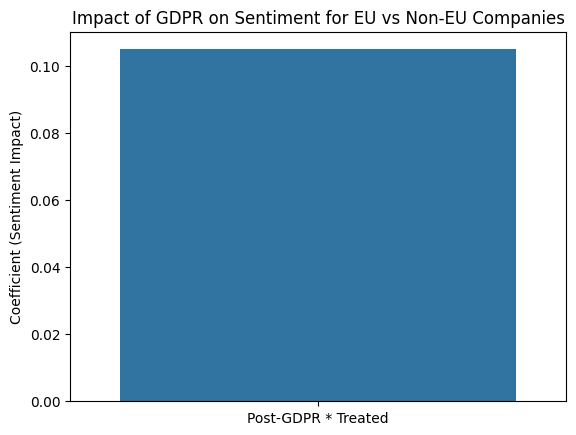

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
# Coefficients from the regression results
coef = model.params

# Extract the coefficient for the interaction term (Post-GDPR * Treated)
interaction_term = coef['post_gdpr:treated']

# Visualizing the results
sns.barplot(x=['Post-GDPR * Treated'], y=[interaction_term])
plt.title('Impact of GDPR on Sentiment for EU vs Non-EU Companies')
plt.ylabel('Coefficient (Sentiment Impact)')
plt.show()


In [ ]:
# Robust standard errors to account for heteroscedasticity
robust_model = model.get_robustcov_results(cov_type='HC3')

# Print the results with robust standard errors
print(robust_model.summary())
